In [10]:
import numpy as np
from scipy.special import erfcinv
from scipy.stats import norm

# Konstanter
c = 3e8  # Lysfart (m/s)
f = 2.425e9  # Frekvens (Hz)
lambda_ = c / f  # Bølgelengde (m)

# Avstandsvektor
d = np.linspace(2, 40, 1000)  # Fra 2 m til 40 m

# ITU-R P.1238-12 parametere for kontor
# Line-of-Sight (LoS)
alpha_LoS, beta_LoS, gamma_LoS, sigma_LoS = 1.46, 34.62, 2.03, 3.76
# Non-Line-of-Sight (NLoS)
alpha_NLoS, beta_NLoS, gamma_NLoS, sigma_NLoS = 2.46, 29.53, 2.38, 5.04

# Beregn path loss (dB) for LoS og NLoS
PL_LoS = 10 * alpha_LoS * np.log10(d) + beta_LoS + 10 * gamma_LoS * np.log10(f/1e9)
PL_NLoS = 10 * alpha_NLoS * np.log10(d) + beta_NLoS + 10 * gamma_NLoS * np.log10(f/1e9)

# Generer stokastisk shadowing
num_realizations = int(1e4)
X_LoS = sigma_LoS * np.random.randn(num_realizations, len(d))
X_NLoS = sigma_NLoS * np.random.randn(num_realizations, len(d))

# Totalt path loss med fading
PL_LoS_total = PL_LoS + X_LoS
PL_NLoS_total = PL_NLoS + X_NLoS

# Beregn middelverdi og std med fading
PL_LoS_mean_fading = np.mean(PL_LoS_total, axis=0)
PL_LoS_std_fading = np.std(PL_LoS_total, axis=0)
PL_NLoS_mean_fading = np.mean(PL_NLoS_total, axis=0)
PL_NLoS_std_fading = np.std(PL_NLoS_total, axis=0)

# --- Beregn sannsynlighet for mottatt signal P_service ---
# Gitte parametere
EIRP, L0, N0, Gr, Rb = -37.7, 6, -166.0, -2.1, 49.0 # dBW, dB, dBW/Hz, dBi, dBHz
BER = 1e-6
Eb_N0 = 10 * np.log10((erfcinv(BER) ** 2) / 2)

# Maksimalt tillatt path loss (LM)
LM = EIRP - L0 - N0 + Gr - Rb - Eb_N0

# Beregn sannsynlighet P_service for LoS og NLoS med small-scale fading
P_service_LoS_fading = norm.cdf(LM, PL_LoS_mean_fading, PL_LoS_std_fading)
P_service_NLoS_fading = norm.cdf(LM, PL_NLoS_mean_fading, PL_NLoS_std_fading)

# --- Finn punktene der P_service >= 99.7 / 95.4 % for LoS og NLoS ---
P_target_LoS, P_target_NLoS = 0.954, 0.954 

# For LoS
idx_LoS = np.argmax(P_service_LoS_fading <= P_target_LoS)
d_LoS = d[idx_LoS]
PL_LoS_at_P_target = -PL_LoS_mean_fading[idx_LoS]

# For NLoS
idx_NLoS = np.argmax(P_service_NLoS_fading <= P_target_NLoS)
d_NLoS = d[idx_NLoS]
PL_NLoS_at_P_target = -PL_NLoS_mean_fading[idx_NLoS]


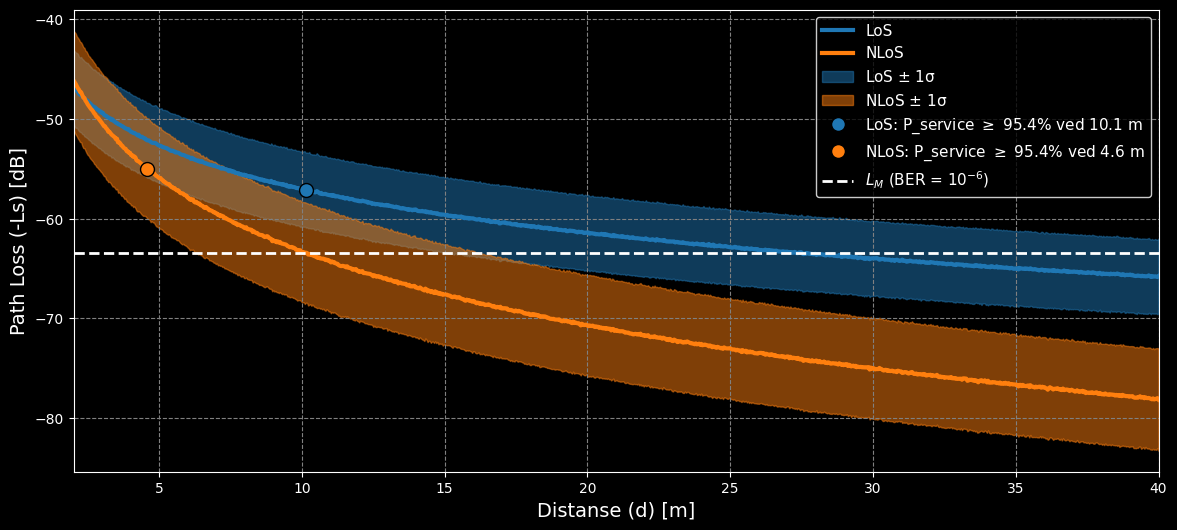

In [11]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# --- PLOT ---
plt.figure(figsize=(14, 6))
plt.grid(True)

# Plot middelverdiene etter small-scale fading
plt.plot(d, -PL_LoS_mean_fading, linewidth=3, label='LoS', color='tab:blue')
plt.plot(d, -PL_NLoS_mean_fading, linewidth=3, label='NLoS', color='tab:orange')

# Skygge rundt middelverdien (±n standardavvik for LoS og NLoS etter fading)
n = 1  # ±n sigma
plt.fill_between(d, -PL_LoS_mean_fading - n * PL_LoS_std_fading, -PL_LoS_mean_fading + n * PL_LoS_std_fading, 
                 color='tab:blue', alpha=0.5, label=rf'LoS $\pm$ {n}σ')
plt.fill_between(d, -PL_NLoS_mean_fading - n * PL_NLoS_std_fading, -PL_NLoS_mean_fading + n * PL_NLoS_std_fading, 
                 color='tab:orange', alpha=0.5, label=rf'NLoS $\pm$ {n}σ')

# Plot de funnet punktene der P_service ≥ 99.7 / 95.4 %
plt.plot(d_LoS, PL_LoS_at_P_target, 'o', markersize=10, markeredgecolor='k', markerfacecolor='tab:blue', 
         label=rf'LoS: P_service $\geq$ {P_target_LoS*100:.1f}% ved {d_LoS:.1f} m')
plt.plot(d_NLoS, PL_NLoS_at_P_target, 'o', markersize=10, markeredgecolor='k', markerfacecolor='tab:orange', 
         label=rf'NLoS: P_service $\geq$ {P_target_NLoS*100:.1f}% ved {d_NLoS:.1f} m')

# Plot LM-linjen som representerer BER = 1e-6
plt.plot(d, np.full_like(d, -LM), 'w--', linewidth=2, label='$L_M$ (BER = $10^{-6}$)')

# Aksetilpasning
plt.grid(which='both', linestyle='--',  color='gray')
plt.xlabel('Distanse (d) [m]', fontsize=14)
plt.ylabel('Path Loss (-Ls) [dB]', fontsize=14)
plt.xlim([min(d), max(d)])
plt.legend(loc='upper right', fontsize=11, edgecolor='white')
plt.savefig("Figurer/LS_Pservice.pdf", format="pdf", bbox_inches="tight")
plt.show()